In [16]:
# ========================================
# 1. Importações e Setup Geral
# ========================================

In [17]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
import itertools

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.datasets import get_rdataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignorar avisos para uma saída mais limpa
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
# =========================================================
# 2. Setup de Reprodutibilidade
# =========================================================

In [19]:
def definir_seed(seed_value=42):
    """Define a semente para reprodutibilidade."""
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    print(f"Semente de reprodutibilidade definida como: {seed_value}")

definir_seed(42)

Semente de reprodutibilidade definida como: 42


In [20]:
# ==============================================
# 3. Funções de Carregamento e Divisão de Dados
# ==============================================

In [21]:
def salvar_dataset(serie, dataset_name):
    """
    Apenas salva uma série temporal em um arquivo CSV local.
    """
    dir_path = "./datasets"
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, f"{dataset_name.lower()}.csv")
    df = pd.DataFrame({"date": serie.index, "value": serie.values})
    df.to_csv(file_path, index=False)
    print(f"-> Cópia do dataset '{dataset_name}' salva em: {file_path}")


def carregar_serie(nome):
    print(f"Buscando dados de '{nome}' via statsmodels...")
    nome_base = nome.lower()

    if nome_base == "airpassengers":
        df = get_rdataset("AirPassengers", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1949-01-01", periods=len(df), freq="MS"),
                          name="AirPassengers")
    elif nome_base == "lynx":
        df = get_rdataset("lynx", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1821", periods=len(df), freq="A"), name="Lynx")
    elif nome_base == "co2":
        df = get_rdataset("CO2", package="datasets").data
        df = df.ffill()
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1958-03-29", periods=len(df), freq="MS"),
                          name="CO2")
    elif nome_base == "sunspots":
        df = get_rdataset("sunspots", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1749-01-01", periods=len(df), freq="MS"),
                          name="Sunspots")
    elif nome_base == "austres":
        df = get_rdataset("austres", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1971-03-01", periods=len(df), freq="QS-MAR"),
                          name="AustralianResidents")
    elif nome_base == "nottem":
        df = get_rdataset("nottem", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1920-01-01", periods=len(df), freq="MS"),
                          name="Nottingham")
    else:
        raise ValueError(f"Série '{nome}' não reconhecida.")

    salvar_dataset(serie, nome)
    return serie


def dividir_serie_temporal(serie, percentual_treino=0.7, percentual_validacao=0.15):
    """Divide a série em treino, validação e teste."""
    # ... (a função que já tínhamos)
    tamanho_total = len(serie)
    ponto_corte_treino = int(tamanho_total * percentual_treino)
    ponto_corte_validacao = int(tamanho_total * (percentual_treino + percentual_validacao))
    treino = serie.iloc[:ponto_corte_treino]
    validacao = serie.iloc[ponto_corte_treino:ponto_corte_validacao]
    teste = serie.iloc[ponto_corte_validacao:]
    return treino, validacao, teste

In [22]:
# =========================================================
# 4. Preparação dos Dados
# =========================================================

In [23]:
NOME_DA_SERIE = "AirPassengers"
serie_completa = carregar_serie(NOME_DA_SERIE)
treino, validacao, teste = dividir_serie_temporal(serie_completa)

print(f"\nTamanho da série de treino: {len(treino)}")
print(f"Tamanho da série de validação: {len(validacao)}")
print(f"Tamanho da série de teste: {len(teste)}")

Buscando dados de 'AirPassengers' via statsmodels...
-> Cópia do dataset 'AirPassengers' salva em: ./datasets\airpassengers.csv

Tamanho da série de treino: 100
Tamanho da série de validação: 22
Tamanho da série de teste: 22


In [24]:
# =========================================================
# 5. Análise Exploratória: Estacionariedade e ACF/PACF
# =========================================================

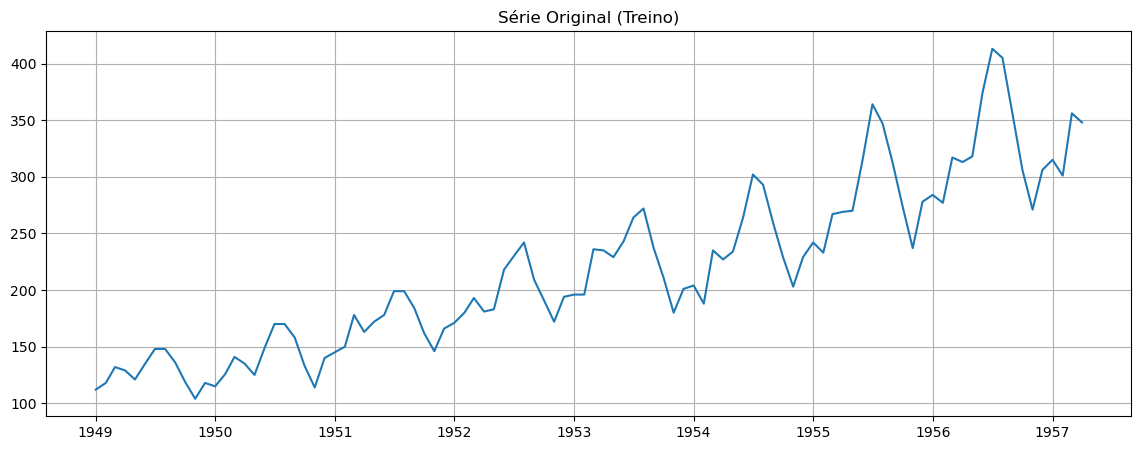

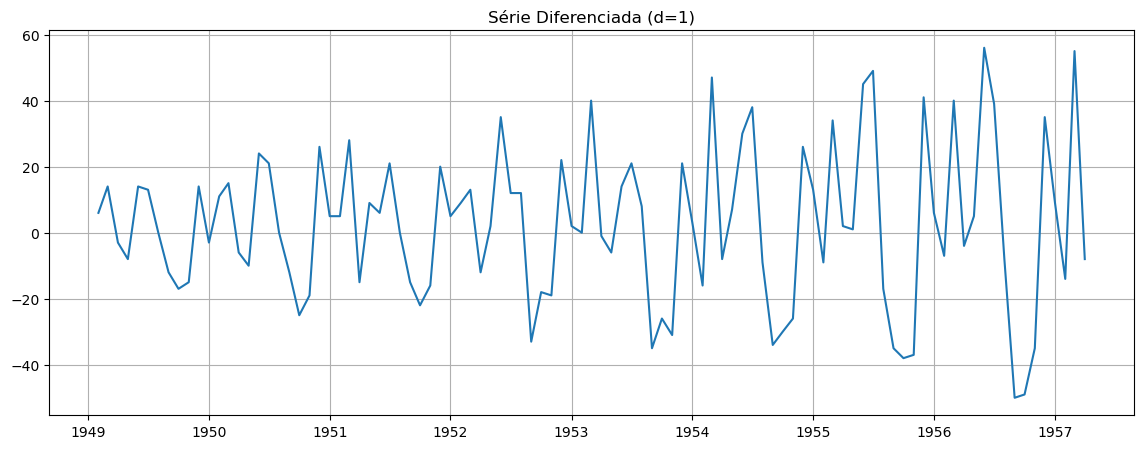

Após uma diferenciação (d=1), a tendência foi removida e a série parece mais estacionária.


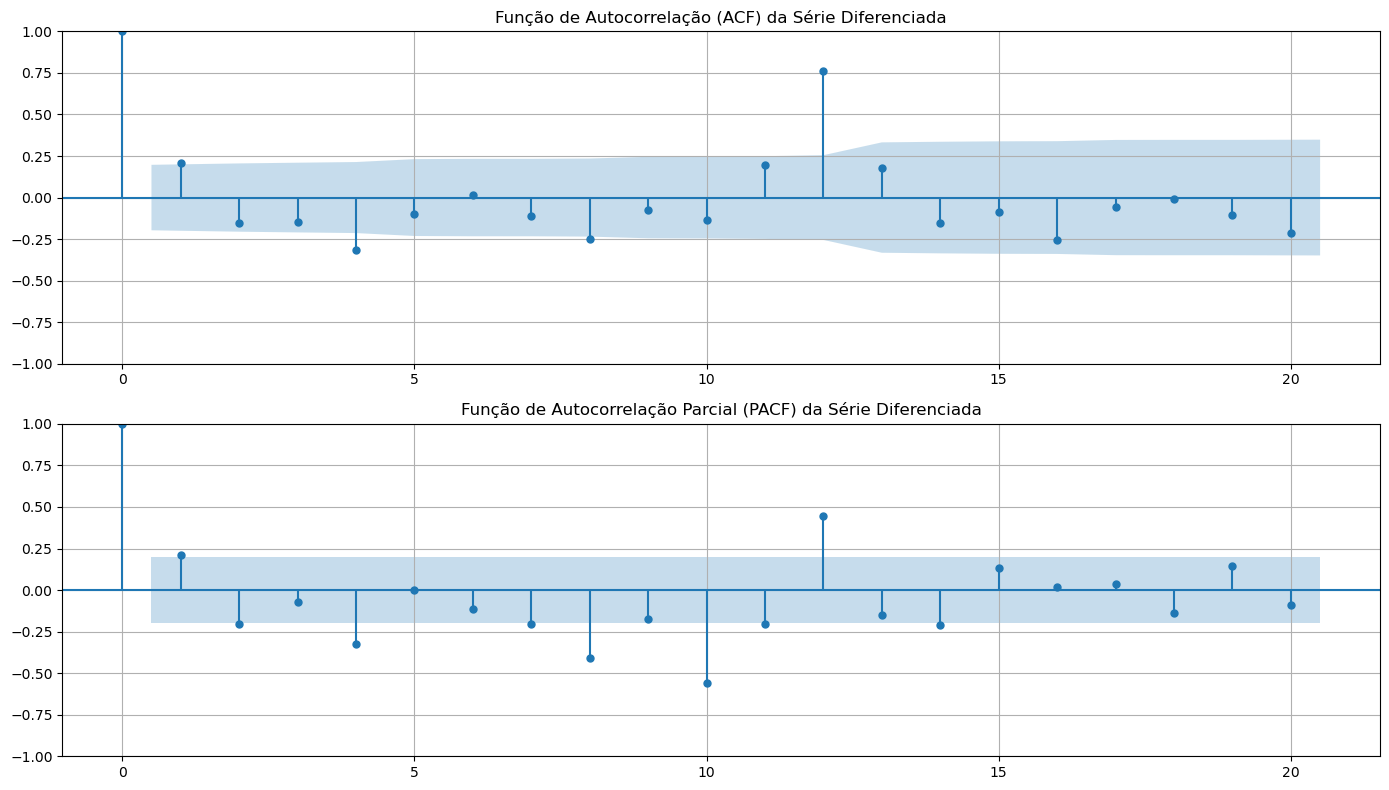


Análise dos Gráficos:
- PACF: Mostra um corte brusco após o lag 1, e outros picos significativos próximos dos lags 8, 11 e 12. Isso sugere que bons valores para 'p' podem estar nesse intervalo.
- ACF: Mostra um comportamento mais decrescente e picos significativos em lags similares.
- Conclusão: Vamos explorar valores de 'p' e 'q' em um range que inclua essas observações, como de 0 a 13.



In [25]:
# --- 5.1 Análise de Estacionariedade (para encontrar 'd') ---
plt.figure(figsize=(14, 5))
plt.title("Série Original (Treino)")
plt.plot(treino)
plt.grid(True)
plt.show()

# A série tem uma clara tendência de alta, então não é estacionária.
# Vamos aplicar uma diferenciação (d=1)
treino_diff = treino.diff().dropna()

plt.figure(figsize=(14, 5))
plt.title("Série Diferenciada (d=1)")
plt.plot(treino_diff)
plt.grid(True)
plt.show()

print("Após uma diferenciação (d=1), a tendência foi removida e a série parece mais estacionária.")
d_estimado = 1

# --- 5.2 Análise ACF e PACF (para estimar ranges de 'p' e 'q') ---
# Usamos a série diferenciada para essa análise
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

plot_acf(treino_diff, lags=20, ax=ax1)
ax1.set_title('Função de Autocorrelação (ACF) da Série Diferenciada')
ax1.grid(True)

plot_pacf(treino_diff, lags=20, ax=ax2)
ax2.set_title('Função de Autocorrelação Parcial (PACF) da Série Diferenciada')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("""
Análise dos Gráficos:
- PACF: Mostra um corte brusco após o lag 1, e outros picos significativos próximos dos lags 8, 11 e 12. Isso sugere que bons valores para 'p' podem estar nesse intervalo.
- ACF: Mostra um comportamento mais decrescente e picos significativos em lags similares.
- Conclusão: Vamos explorar valores de 'p' e 'q' em um range que inclua essas observações, como de 0 a 13.
""")


In [26]:
# =========================================================
# 6. Validação de Modelos (Grid Search com RMSE/MAE)
# =========================================================

In [27]:
# =========================================================
# 5. Validação de Modelos (Grid Search com RMSE/MAE)
# =========================================================

def validar_modelos_arima(treino, validacao, p_range, d_fixo, q_range):
    """
    Testa combinações de ARIMA e avalia o RMSE e MAE no conjunto de validação.
    """
    print("\nIniciando a validação de modelos ARIMA...")
    resultados = []
    treino_com_freq = treino.asfreq(treino.index.freqstr)

    # Usando a lista de ordens candidatas que definimos
    combinacoes = list(itertools.product(p_range, [d_fixo], q_range))
    combinacoes.append((12, d_fixo, 1)) # Adicionando manualmente a ordem sazonal
    print(f"Testando {len(combinacoes)} combinações...")

    for ordem in combinacoes:
        try:
            modelo = ARIMA(treino_com_freq, order=ordem).fit()
            previsoes = modelo.predict(start=validacao.index[0], end=validacao.index[-1])
            rmse = np.sqrt(mean_squared_error(validacao, previsoes))
            mae = mean_absolute_error(validacao, previsoes)
            resultados.append({'ordem': ordem, 'RMSE': rmse, 'MAE': mae})
        except Exception:
            continue

    print("Validação concluída.")
    return pd.DataFrame(resultados)

# --- FUNÇÃO DE EXIBIÇÃO CORRIGIDA ---
def exibir_resultados_validacao(df_resultados):
    """
    Exibe a tabela de resultados da validação, destacando a melhor linha (menor RMSE).
    """
    if df_resultados.empty:
        print("Nenhum resultado de validação para exibir.")
        return

    df_sorted = df_resultados.sort_values(by='RMSE').reset_index(drop=True)
    idx_melhor_rmse = df_sorted['RMSE'].idxmin()

    def destacar_melhor(s):
        estilo = 'background-color: #4285F4; color: white;'
        return [estilo if s.name == idx_melhor_rmse else '' for i in s]

    # Dicionário para formatar apenas as colunas numéricas (RMSE e MAE)
    # Aumentei para 4 casas decimais para maior precisão na visualização dos erros
    format_dict = {'RMSE': '{:.4f}', 'MAE': '{:.4f}'}

    print("\n--- Top 10 Melhores Modelos (por RMSE na Validação) ---")
    display(df_sorted.head(10).style.apply(destacar_melhor, axis=1).format(format_dict))

# --- Execução da Validação ---

# Definindo o range para a busca, com base na análise ACF/PACF
p_vals = range(0, 4)
q_vals = range(0, 4)
d_estimado = 1 # Definido na Seção 4

# Executando a validação
df_resultados_validacao = validar_modelos_arima(treino, validacao, p_vals, d_estimado, q_vals)

# Exibindo os resultados com a função corrigida
exibir_resultados_validacao(df_resultados_validacao)

# Selecionando a melhor ordem
if not df_resultados_validacao.empty:
    melhor_ordem_final = df_resultados_validacao.sort_values(by='RMSE').iloc[0]['ordem']
    print(f"\nMelhor ordem selecionada: {melhor_ordem_final}")
else:
    print("\nNenhuma ordem válida foi encontrada. Usando uma ordem padrão.")
    melhor_ordem_final = (1, 1, 1) # Fallback


Iniciando a validação de modelos ARIMA...
Testando 17 combinações...
Validação concluída.

--- Top 10 Melhores Modelos (por RMSE na Validação) ---


,ordem,RMSE,MAE
0,"(12, 1, 1)",19.2177,14.8506
1,"(0, 1, 0)",66.5920,46.2273
2,"(3, 1, 3)",67.6122,50.5952
3,"(1, 1, 0)",67.6890,46.9092
4,"(1, 1, 1)",71.0049,49.5162
5,"(0, 1, 1)",71.6272,49.9467
6,"(2, 1, 0)",73.8120,52.1612
7,"(3, 1, 0)",74.1050,52.3514
8,"(0, 1, 2)",76.1017,55.0303
9,"(2, 1, 2)",78.2259,57.3262



Melhor ordem selecionada: (12, 1, 1)


In [28]:
# =========================================================
# 7. Treinamento Final e Avaliação no Conjunto de Teste
# =========================================================

In [29]:
print("\nTreinando o modelo final com os dados de Treino + Validação...")
# Unimos treino e validação para o treinamento final
treino_validacao = pd.concat([treino, validacao]).asfreq('MS')

# Treinando o modelo final com a melhor ordem encontrada
modelo_final = ARIMA(treino_validacao, order=melhor_ordem_final).fit()

print("Fazendo previsões no conjunto de Teste...")
previsoes_finais = modelo_final.predict(start=teste.index[0], end=teste.index[-1])

# Calculando o erro final no conjunto de teste
rmse_final = np.sqrt(mean_squared_error(teste, previsoes_finais))
mae_final = mean_absolute_error(teste, previsoes_finais)

print("\n--- Desempenho Final no Conjunto de Teste ---")
print(f"RMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")


Treinando o modelo final com os dados de Treino + Validação...
Fazendo previsões no conjunto de Teste...

--- Desempenho Final no Conjunto de Teste ---
RMSE Final: 57.17
MAE Final: 52.40


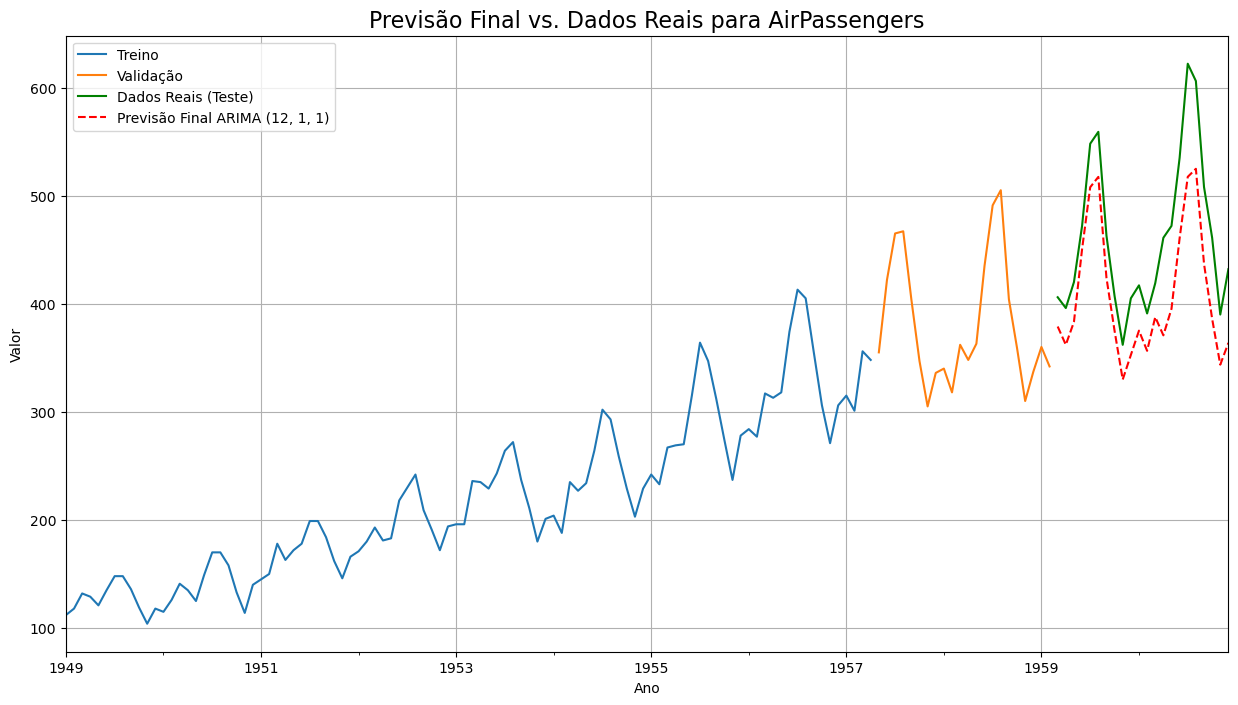

In [30]:
# =========================================================
# 8. Visualização Final
# =========================================================
fig, ax = plt.subplots(figsize=(15, 8))
treino.plot(ax=ax, label='Treino')
validacao.plot(ax=ax, label='Validação')
teste.plot(ax=ax, label='Dados Reais (Teste)', color='green')
previsoes_finais.plot(ax=ax, label=f'Previsão Final ARIMA {melhor_ordem_final}', color='red', linestyle='--')

ax.set_title(f'Previsão Final vs. Dados Reais para {NOME_DA_SERIE}', fontsize=16)
ax.set_xlabel('Ano')
ax.set_ylabel('Valor')
ax.legend()
plt.grid(True)
plt.show()